## Best model: XGBoost with 50 estimators with AUC of 0.81 on test data

In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# Overview of data

In [4]:
# Loading the dataset
data = pd.read_csv("/content/term deposit data.csv", sep=";")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
print(data["y"].value_counts())

no     36548
yes     4640
Name: y, dtype: int64


# Exploratory Data Analysis

### Distribution of response value

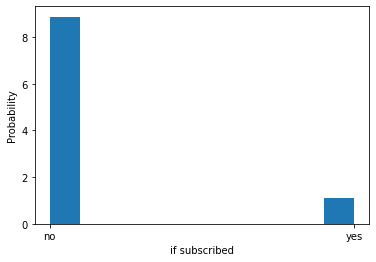

In [8]:
%matplotlib inline
plt.hist(data["y"], density=True)
plt.ylabel('Probability')
plt.xlabel('if subscribed')
plt.show()

Imbalanced: AUC

# Variables

## Categorical variable

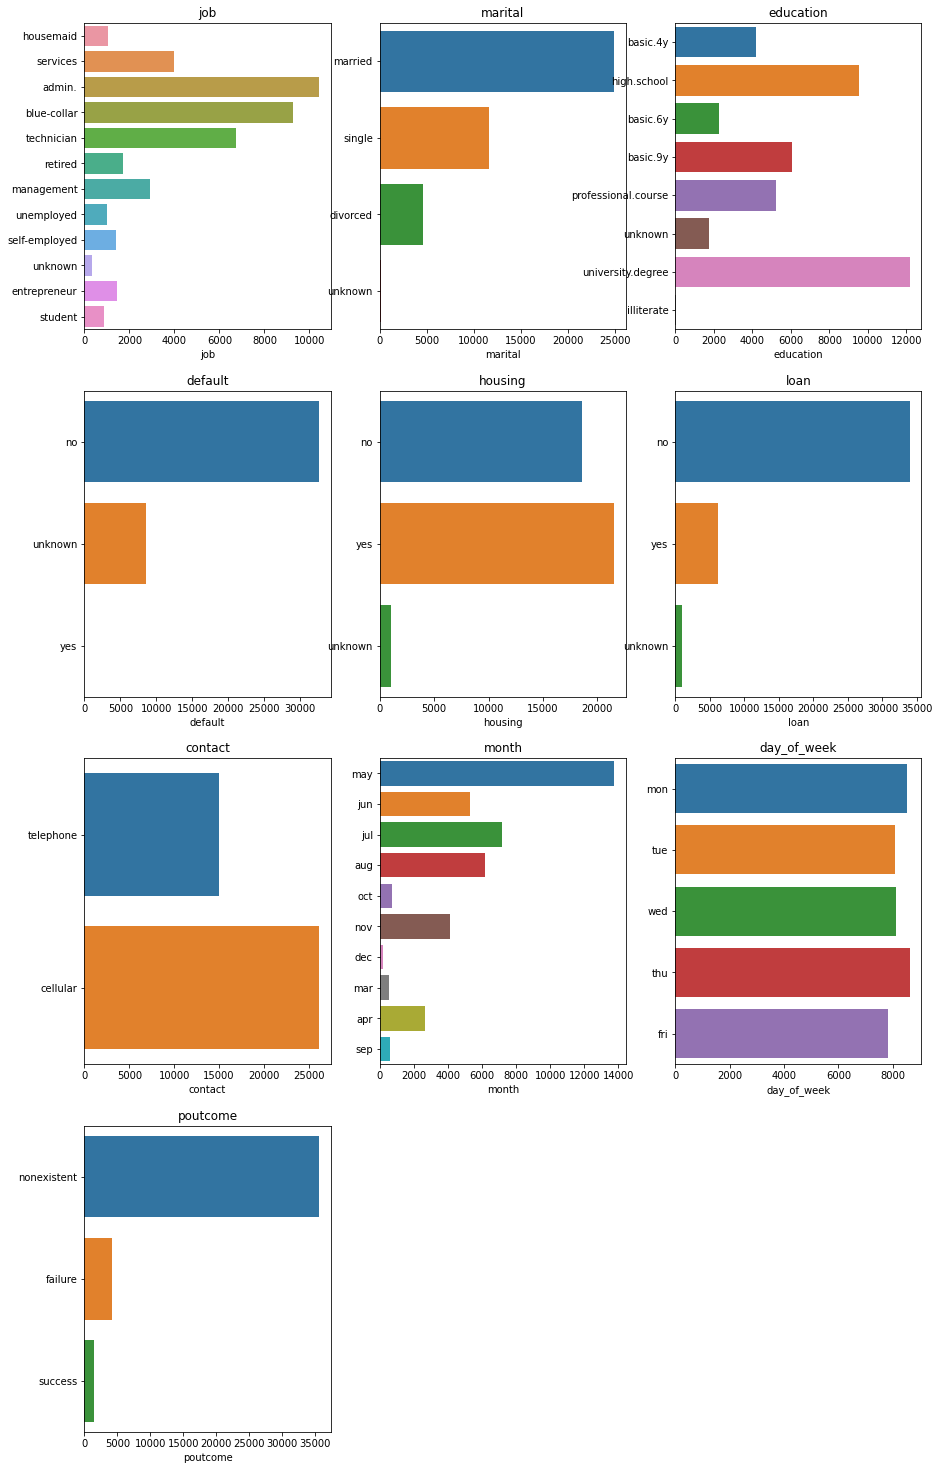

In [9]:
categorical_features = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
numerical_features = ['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
plt.figure(figsize=(15,80), facecolor='white')
plotnumber =1
for categorical_feature in categorical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.countplot(y=categorical_feature,data=data)
    plt.xlabel(categorical_feature)
    plt.ylabel("")
    plt.title(categorical_feature)
    plotnumber+=1
plt.show()

defualt feature does not play importand role, which can be removed.

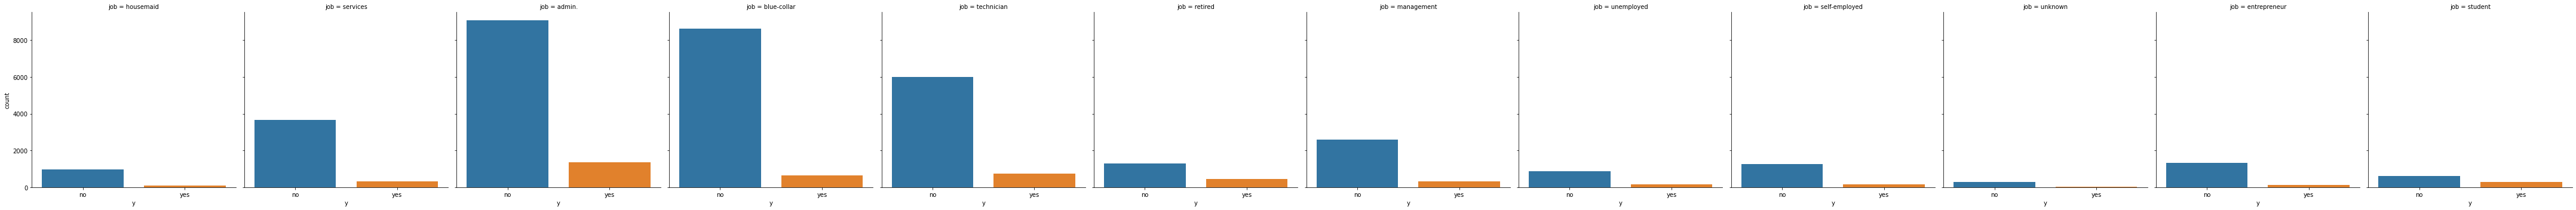

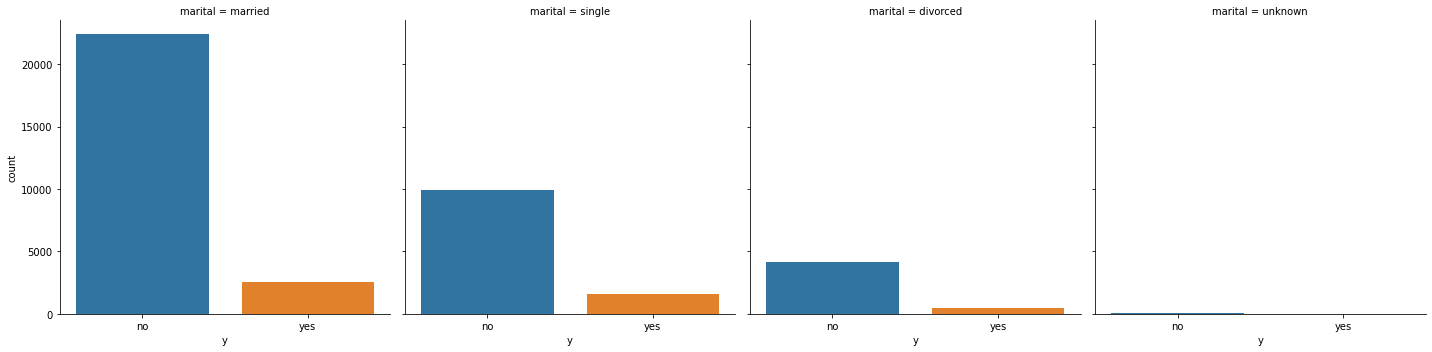

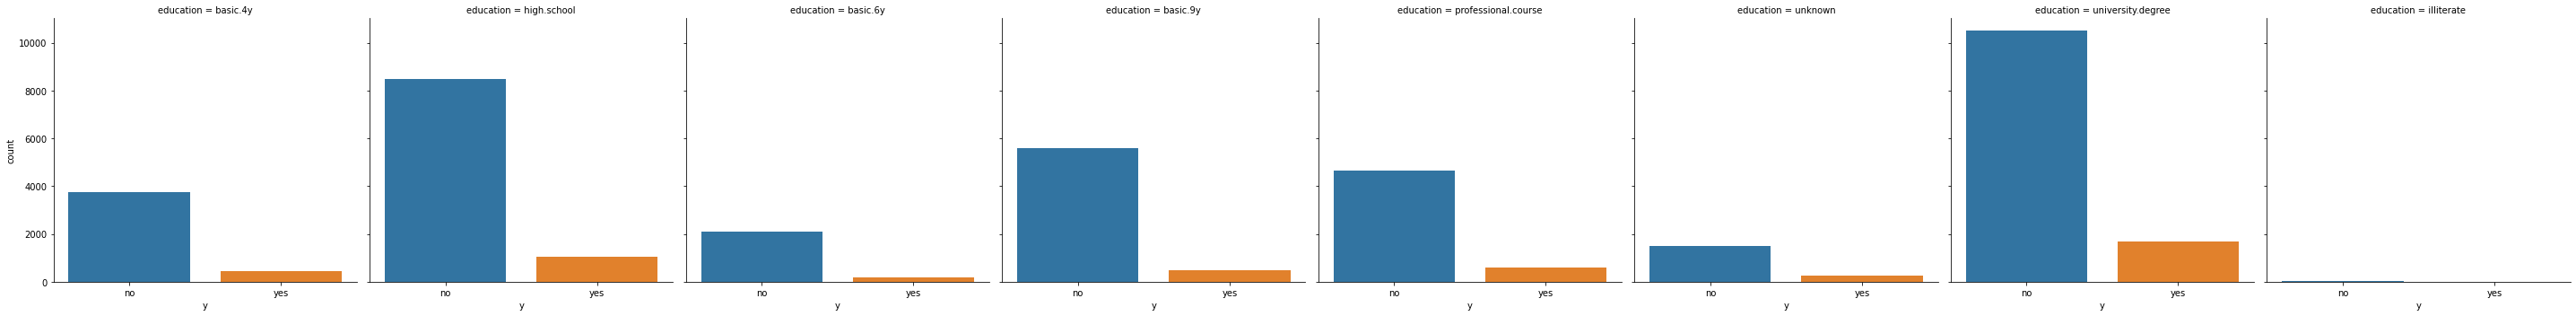

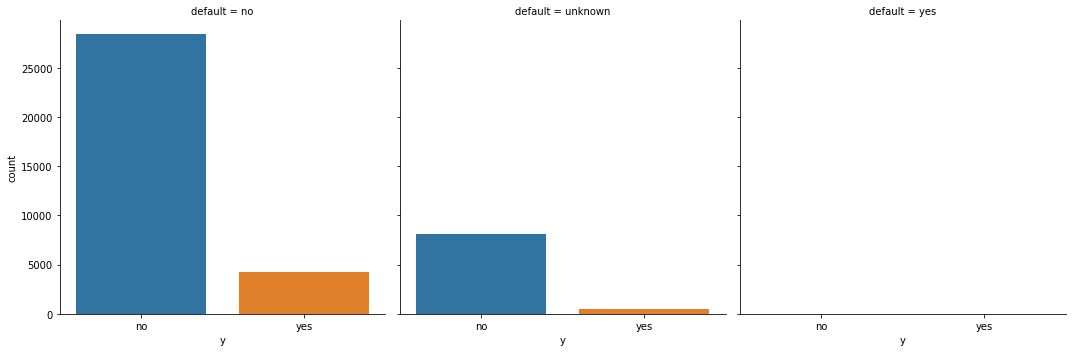

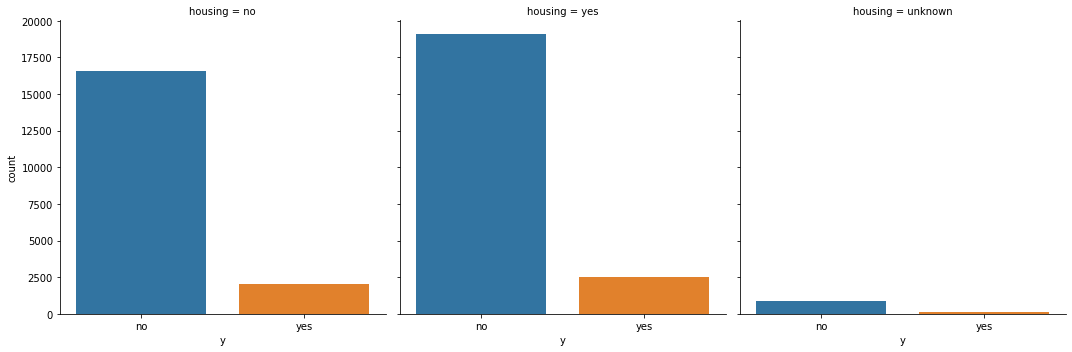

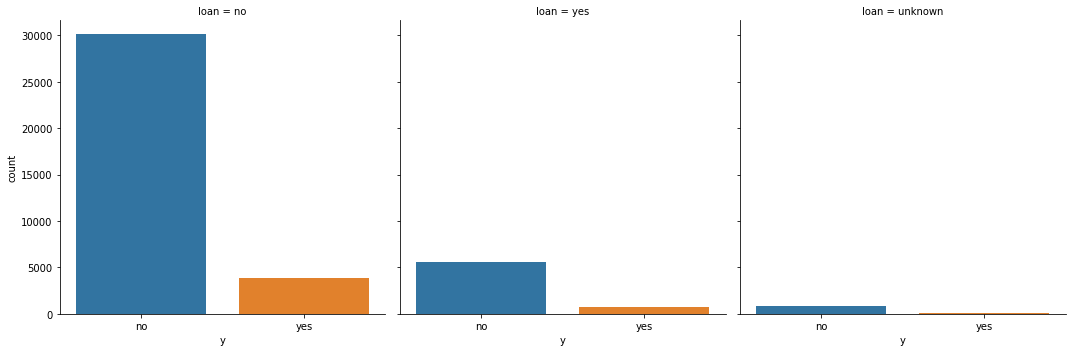

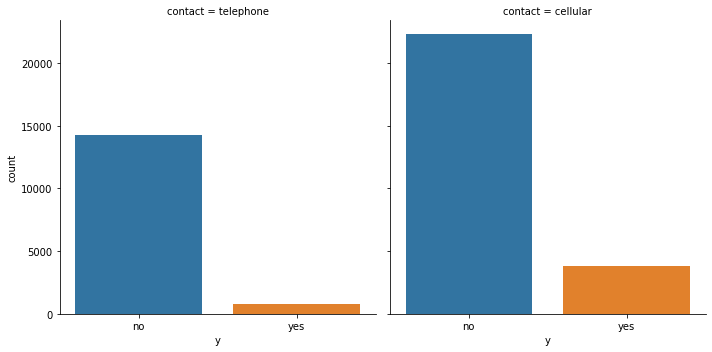

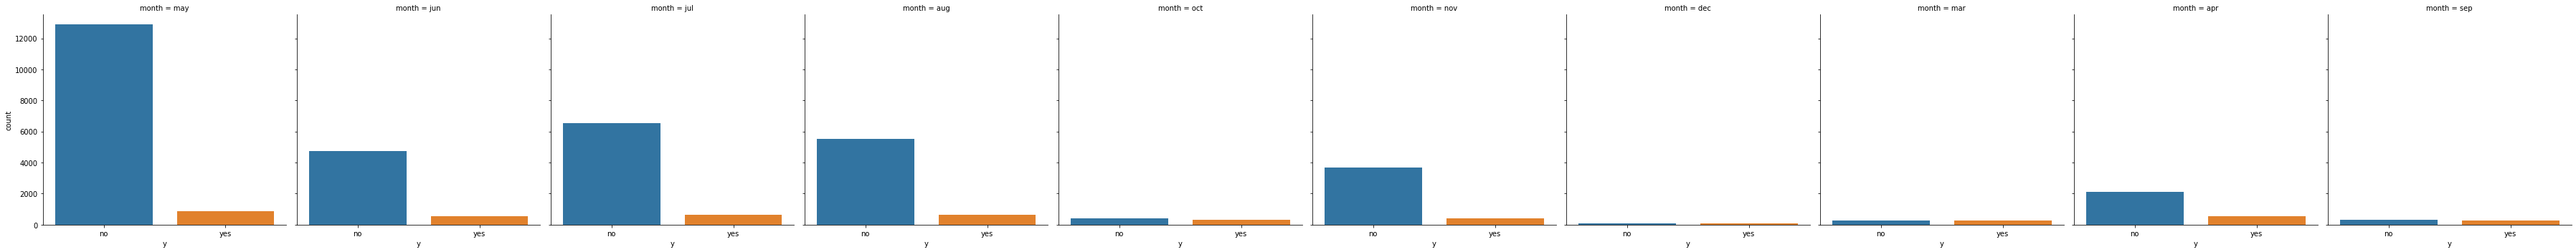

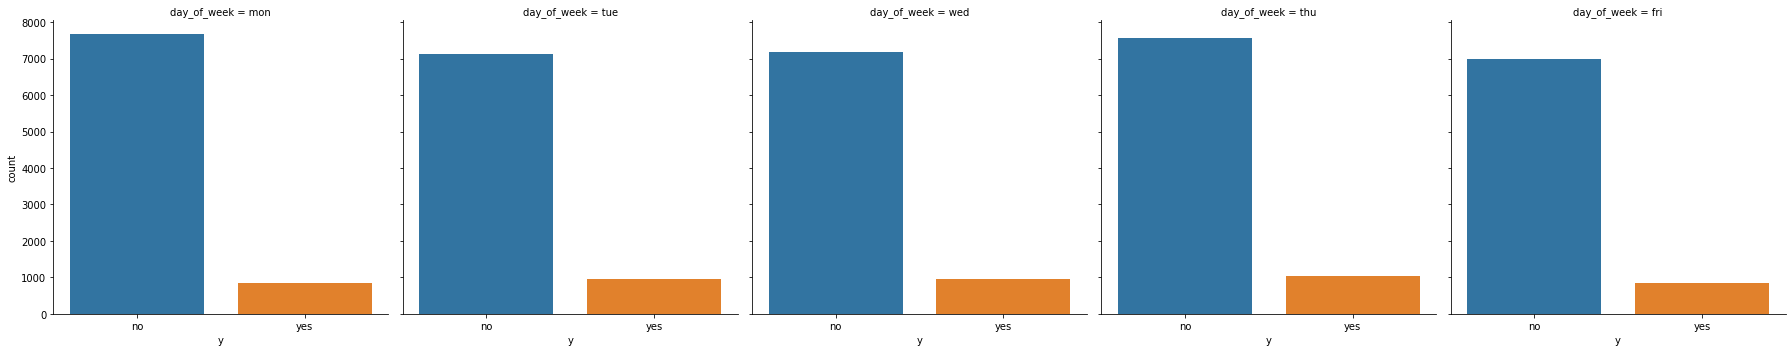

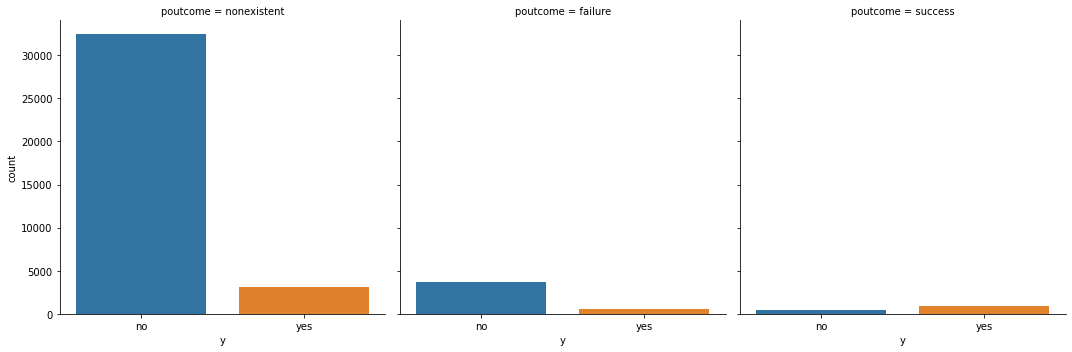

In [10]:
for categorical_feature in categorical_features:
    sns.catplot(x='y', col=categorical_feature, kind='count', data= data)
plt.show()

## Numeric variable

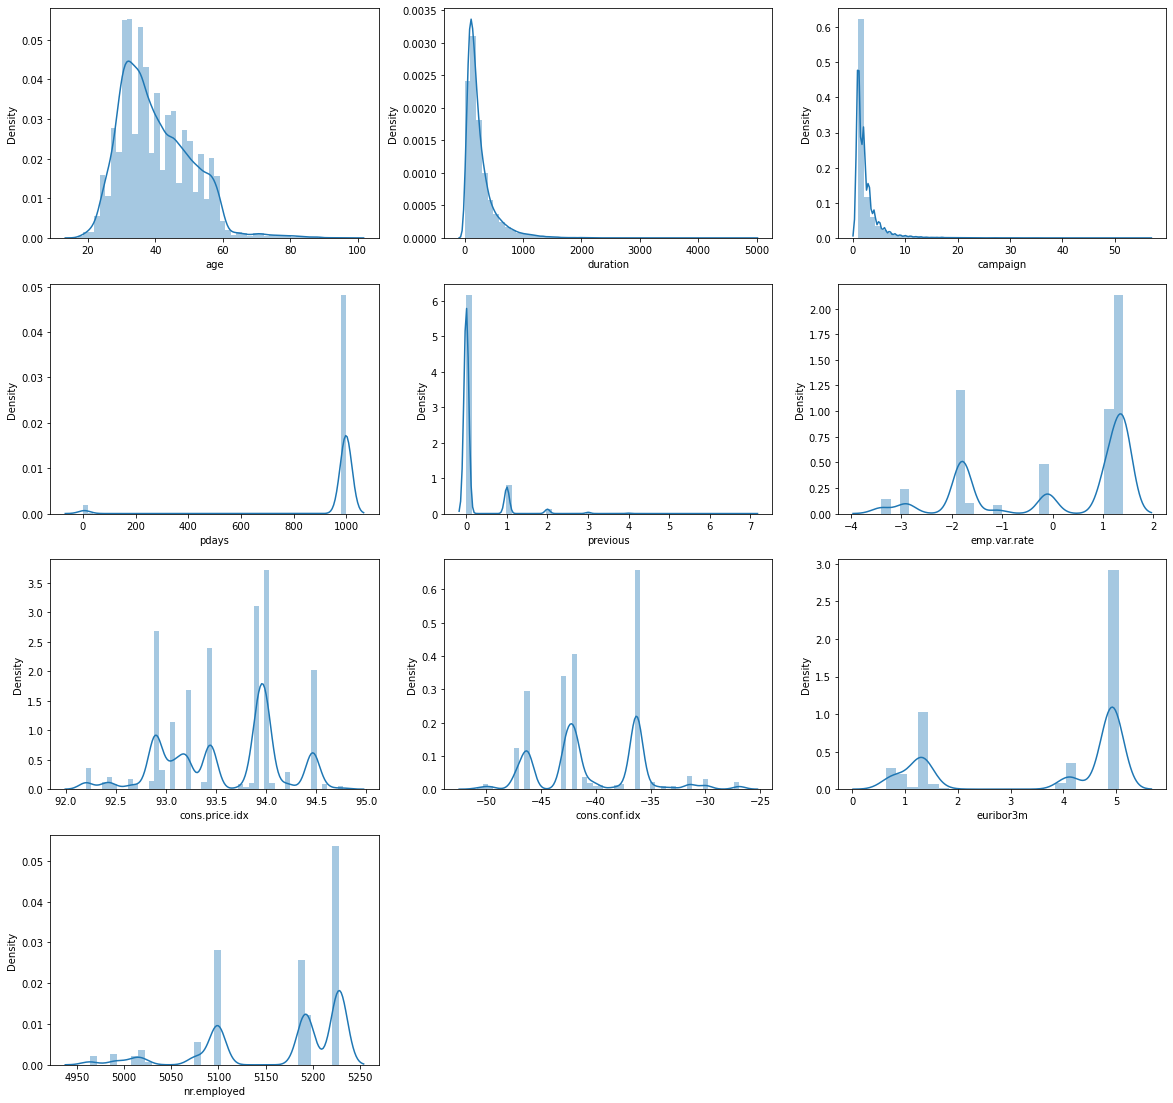

In [11]:
plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for numerical_feature in numerical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.distplot(data[numerical_feature])
    plt.xlabel(numerical_feature)
    plotnumber+=1
plt.show()

duration, compaign, previous heavely skewed towards left

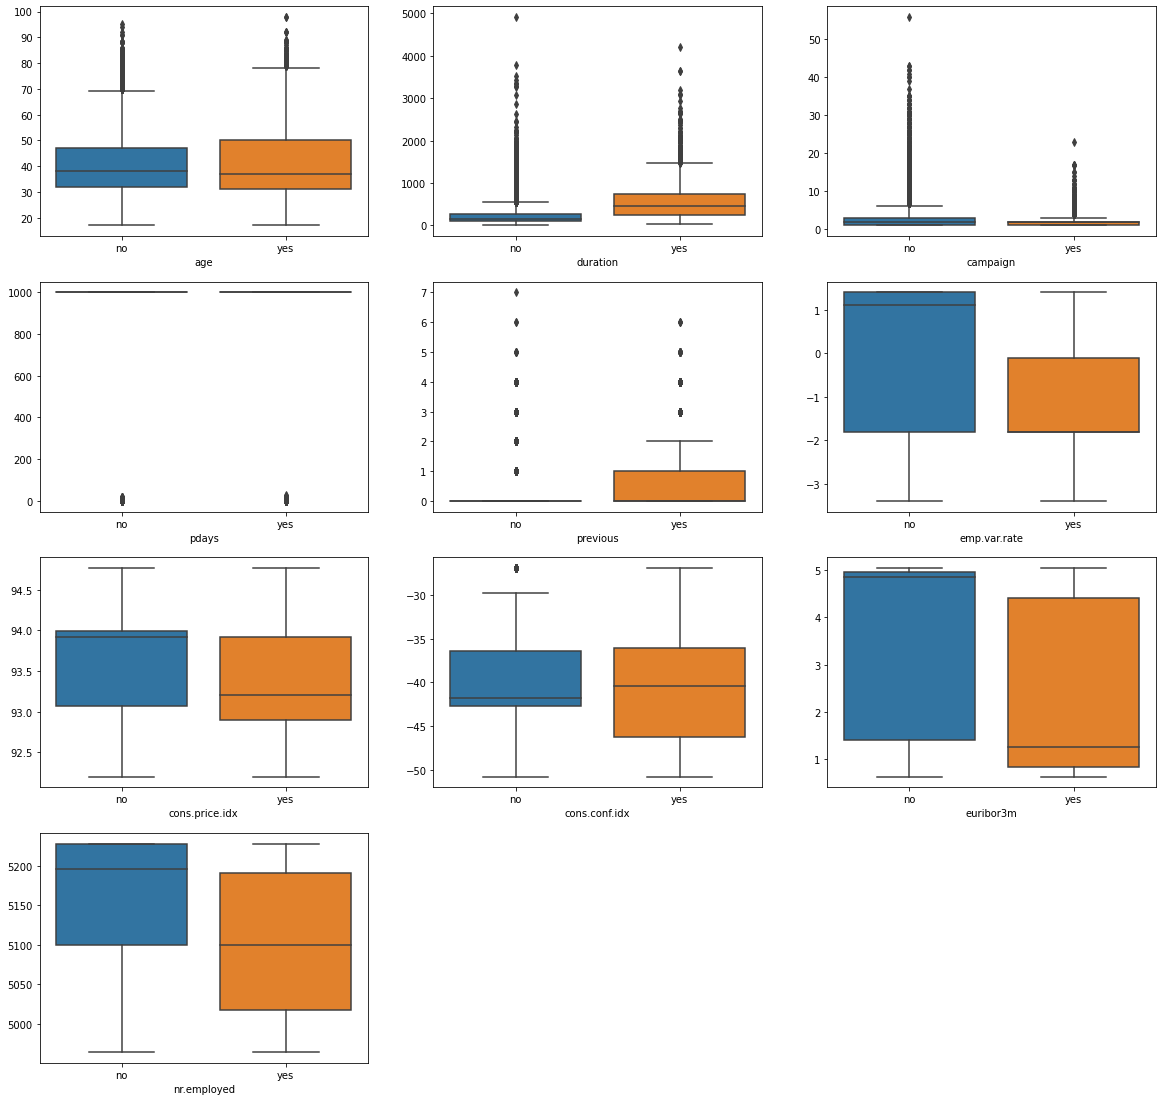

In [12]:
plt.figure(figsize=(20,60), facecolor='white')
plotnumber =1
for feature in numerical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.boxplot(x="y", y= data[feature], data=data)
    plt.xlabel(feature)
    plt.ylabel("")
    plotnumber+=1
plt.show()

## Correlation matrix of numerical features

Text(0.5, 1.0, 'Pearson correlation of Features')

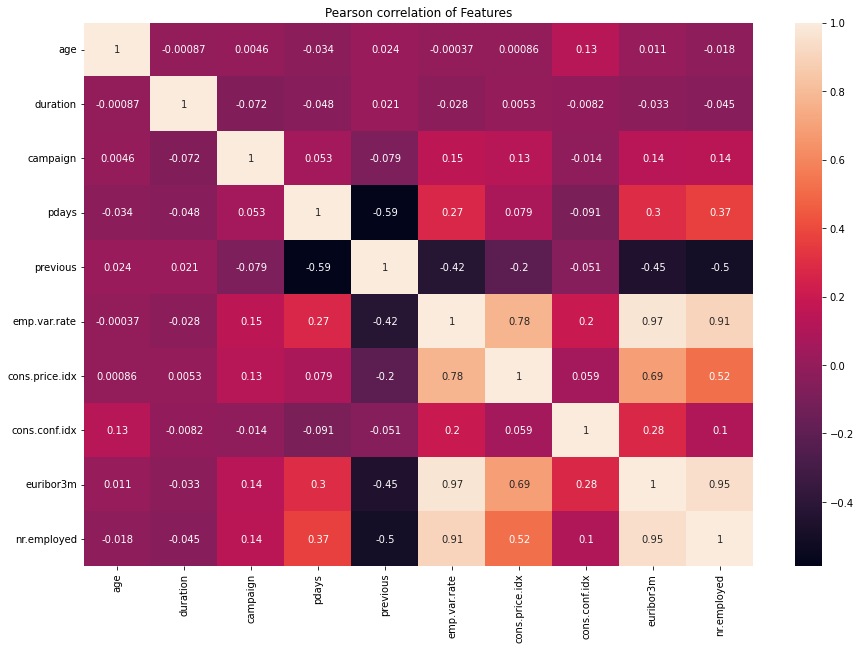

In [15]:
cor_mat=data.corr()
fig = plt.figure(figsize=(15,10))
sns.heatmap(cor_mat,annot=True)
plt.title("Pearson correlation of Features")

nr.employed and euribor3m have a correlation value of 0.95, and euribor3m and emp.var.rate have a correlation of 0.97, we will remove emp.var.rate.

# Data Preprocessing
missing data, remove duplicate data, drop features, one-hot encoding for categorical features. 

In [16]:
data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

There are no missing values in this dataset.

## Dealing with duplicate data

In [17]:
data[data.duplicated(keep="last")]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,124,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,88,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,331,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,43,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,128,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20072,55,services,married,high.school,unknown,no,no,cellular,aug,mon,33,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20531,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,127,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25183,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,123,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28476,24,services,single,high.school,no,yes,no,cellular,apr,tue,114,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32505,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,348,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


In [18]:
data = data.drop_duplicates()
data.shape

(41176, 21)

In [19]:
data.drop(['default'],axis=1, inplace=True)
data.drop(['emp.var.rate'],axis=1, inplace=True)
data.drop(['duration'],axis=1, inplace=True)

In [20]:
data.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,999,0,nonexistent,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,no,no,telephone,may,mon,1,999,0,nonexistent,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,yes,no,telephone,may,mon,1,999,0,nonexistent,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,999,0,nonexistent,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,yes,telephone,may,mon,1,999,0,nonexistent,93.994,-36.4,4.857,5191.0,no


In [21]:
data.shape

(41176, 18)

In [22]:
cat_columns = ['job', 'marital', 'education', 'contact', 'month','day_of_week','poutcome']
for col in  cat_columns:
    data = pd.concat([data.drop(col, axis=1),pd.get_dummies(data[col], prefix=col, prefix_sep='_',drop_first=True, dummy_na=False)], axis=1)

In [23]:
bool_columns = ['housing', 'loan', 'y']
for col in  bool_columns:
    data[col+'_new']=data[col].apply(lambda x : 1 if x == 'yes' else 0)
    data.drop(col, axis=1, inplace=True)

## Train Test split

In [24]:
X = data.drop(['y_new'],axis=1)
y = data['y_new']
from sklearn.model_selection import train_test_split
X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_cv, y_train, y_cv = train_test_split(X_rest, y_rest, test_size=0.2)
len(X_train)

26352

In [25]:
len(X_test)

8236

In [26]:
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Model Selection

AUC for k =  1e-05 is 0.7563526430977796
AUC for k =  0.0001 is 0.7682429564996446
AUC for k =  0.001 is 0.7777243923294346
AUC for k =  0.01 is 0.7901839252585703
AUC for k =  0.1 is 0.7907878340645111
AUC for k =  1 is 0.7782909087960297
AUC for k =  10 is 0.790807881764522
AUC for k =  100 is 0.7933007794725967
AUC for k =  1000 is 0.7906299302700448


<IPython.core.display.Javascript object>

With best c =  100 The train AUC is: 0.7844237365903997
With best c =  100 The cross validation AUC is: 0.7933007794725967
With best c =  100 The test AUC is: 0.7697322022782821


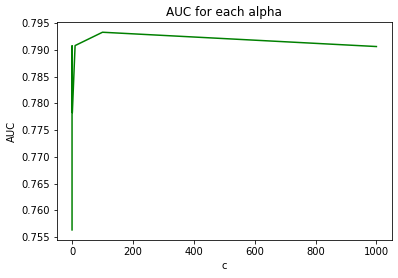

In [28]:
alpha = [10 ** x for x in range(-5, 4)]
cv_auc_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array.append(roc_auc_score(y_cv, predict_y[:,1]))
    
for i in range(len(cv_auc_array)):
    print ('AUC for k = ',alpha[i],'is',cv_auc_array[i])

best_alpha = np.argmax(cv_auc_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array,c='g')
plt.title("AUC for each alpha")
plt.xlabel("c")
plt.ylabel("AUC")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('With best c = ', alpha[best_alpha], "The train AUC is:",roc_auc_score(y_train, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_cv)
print('With best c = ', alpha[best_alpha], "The cross validation AUC is:",roc_auc_score(y_cv, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_test)
print('With best c = ', alpha[best_alpha], "The test AUC is:",roc_auc_score(y_test, predict_y[:,1]))

In [16]:
alpha=[10,50,100,500]
cv_auc_array_rf=[]
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array_rf.append(roc_auc_score(y_cv, predict_y[:,1]))
    
for i in range(len(cv_auc_array_rf)):
    print ('CV AUC for number of estimators = ',alpha[i],'is',cv_auc_array_rf[i])

CV AUC for number of estimators =  10 is 0.7716744846010201
CV AUC for number of estimators =  50 is 0.7781203925724199
CV AUC for number of estimators =  100 is 0.7788536026994477
CV AUC for number of estimators =  500 is 0.7781997171800463


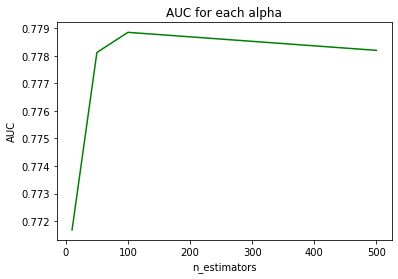

With best n_estimators =  100 The train AUC is: 0.9997041184021412
With best n_estimators  =  100 The cross validation AUC is: 0.7788536026994477
With best n_estimators  =  100 The test AUC is: 0.798215854418798


In [19]:
best_alpha = np.argmax(cv_auc_array_rf)
fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array_rf,c='g')
plt.title("AUC for each alpha")
plt.xlabel("n_estimators")
plt.ylabel("AUC")
plt.show()

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('With best n_estimators = ', alpha[best_alpha], "The train AUC is:",roc_auc_score(y_train, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_cv)
print('With best n_estimators  = ', alpha[best_alpha], "The cross validation AUC is:",roc_auc_score(y_cv, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_test)
print('With best n_estimators  = ', alpha[best_alpha], "The test AUC is:",roc_auc_score(y_test, predict_y[:,1]))

[07:55:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:55:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:55:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:55:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

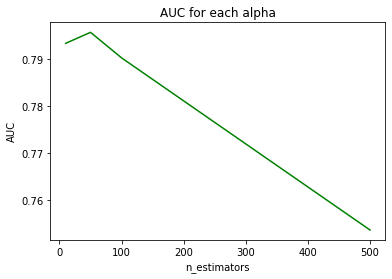

In [26]:
alpha=[10,50,100,500]
cv_auc_array_xgb=[]
for i in alpha:
    x_cfl=x_cfl=XGBClassifier(n_estimators=i)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_auc_array_xgb.append(roc_auc_score(y_cv, predict_y[:,1]))
    
for i in range(len(cv_auc_array_xgb)):
    print ('AUC for number of estimators = ',alpha[i],'is',cv_auc_array_xgb[i])

best_alpha = np.argmax(cv_auc_array_xgb)
fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_array_xgb,c='g')
plt.title("AUC for each alpha")
plt.xlabel("n_estimators")
plt.ylabel("AUC")
plt.show()

In [25]:
x_cfl=XGBClassifier(n_estimators = alpha[best_alpha])
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('With best n_estimators = ', alpha[best_alpha], "The train AUC is:",roc_auc_score(y_train, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_cv)
print('With best n_estimators = ', alpha[best_alpha], "The cross validation AUC is:",roc_auc_score(y_cv, predict_y[:,1]))
predict_y = sig_clf.predict_proba(X_test)
print('With best n_estimators = ', alpha[best_alpha], "The test AUC is:",roc_auc_score(y_test, predict_y[:,1]))

[07:54:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:54:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:54:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:54:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

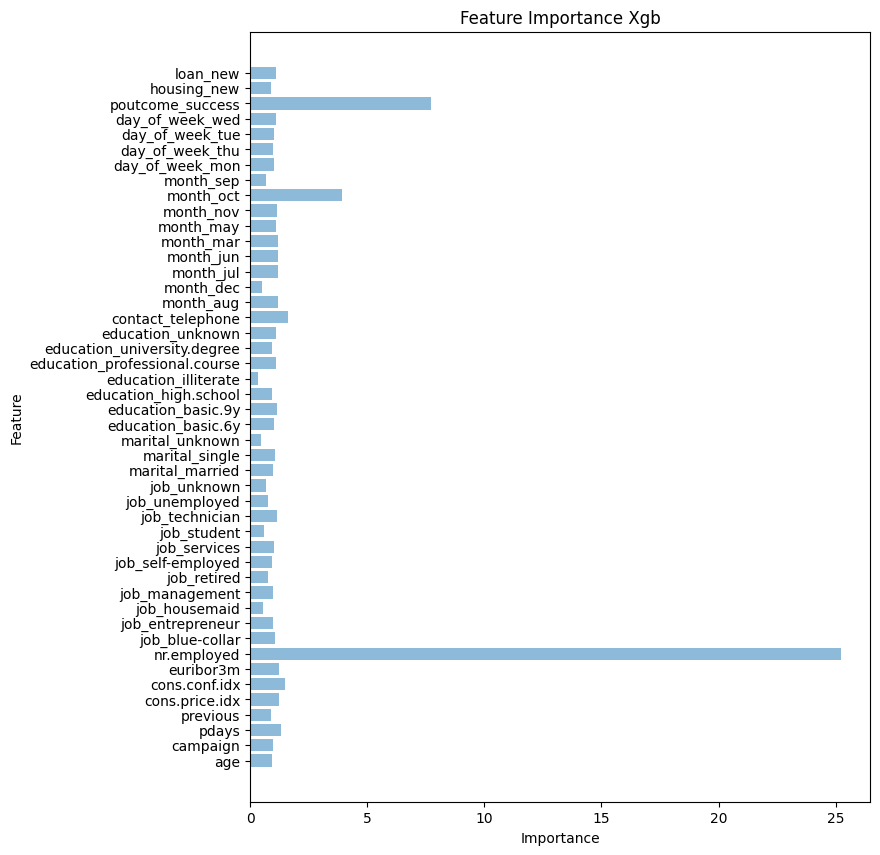

In [30]:
plt.rcdefaults()
feature_importance = x_cfl.get_booster().get_score(importance_type='gain')
objects = feature_importance.keys()
y_pos = np.arange(len(objects))
performance = feature_importance.values()
plt.figure(figsize=(8,10))
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Xgb')
plt.show()

Most relevent features:

nr.employed

poutcome_success

month_oct


# Conclusion

| Model  | Train AUC  | Test AUC  |
|---|---|---|
| Logistic Regression  | 0.784  | 0.769  |
| Random forest  | 0.999  | 0.798  |
| Xgboost  | 0.882  | 0.813  |


Underfitting: Increase model complexity

Overfitting: 

Feature selection

CV

Regularization

Bagging

Boosting
